# HW5 Least Squares

## Q1. Spline fitting

In [1]:
using CSV;
data = CSV.read("xy_data.csv");

### a). Polynomial

\begin{align}
\underset{a_1, a_2, a_3, a_4}{\text{minimize}} \qquad& \sum_{i}(x_i^3a_1+x_i^2a_2+x_ia_3+a_4 - y_i)^2  \\
\text{subject to:}\qquad& a_4 = 0 &&\text{(constraint 1)}\\ 
\end{align}
constraint1 ->the fluorescence is 0 at 0 intensity

In [2]:
#using Pkg
#Pkg.add("Gurobi")

In [3]:
#Pkg.build("Gurobi")
using JuMP, LinearAlgebra, Ipopt;

In [4]:
(r,c) = size(data);

highest_order = 3;
Xc = highest_order + 1;
X = zeros((r,Xc));
for i = 1:Xc
    X[:,Xc-i+1] = data[:,1].^(i-1);
end

m1 = Model(with_optimizer(Ipopt.Optimizer))
set_silent(m1);
a = @variable(m1, [1:Xc]);
residual1 = @variable(m1, [1:r,1]);
residual2 = @variable(m1, [1:r,1]);
@constraint(m1, a[Xc] == 0);

for i = 1:r
    @constraint(m1, residual1[i] - ((X[i,:]' * a - data[i,2])).^2 == 0);
    
    
end

@objective(m1, Min, sum(residual1));
optimize!(m1);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4176
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1990

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

In [5]:
println("The best fitted 'a' values are ->", round.(value.(a),digits = 6));

The best fitted 'a' values are ->[0.009324, -0.13453, 0.5111, -0.0]


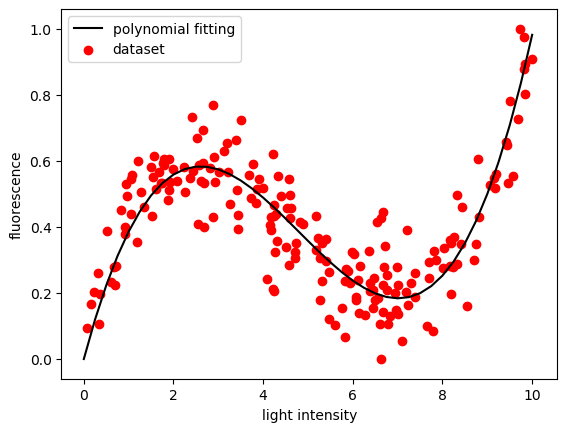

In [6]:
## plot
using PyPlot;
Xcordinate = 0:0.25:10;
X_plot = zeros(length(Xcordinate),Xc);
for i = 1:Xc
    X_plot[:,Xc - i + 1] = Xcordinate.^(i-1);
end
Y_plot = X_plot * value.(a);

figure();
plot(Xcordinate,Y_plot, label = "polynomial fitting", c = "k");
scatter(data[:,1], data[:,2], label = "dataset", c = "r");
xlabel("light intensity");
ylabel("fluorescence");
legend();

### b). Spline 

\begin{align}
\underset{p_1, p_2, p_3,q_1,q_2,q_3}{\text{minimize}} \qquad & \sum_i^{0 \leq x_i < 4}{(x_i^2p_1+x_ip_2+p_3 - y_i)^2 } + \sum_i^{4 \leq x_i \leq 10}{(x_i^2q_1+x_iq_2+q_3 - y_i)^2 }\\
\text{subject to:}\qquad& 16p_1 + 4p_2 + p_3 = 16q_1 + 4q_2 + q_3 &&\text{(constraint 1)}\\ 
\text{subject to:}\qquad& 8p_1 + p_2  = 8q_1 + q_2  &&\text{(constraint 2)}\\ 
\text{subject to:}\qquad& p_3 = 0  &&\text{(constraint 3)}
\end{align}

constraint 1: two pieces have the same value at intensity = 4; 
constraint 2: two pieces have the same slope at 4; 
constraint 3: fluorenscence is 0 at 0;

In [7]:
X_le4 = [];
Y_le4 = [];
X_ge4 = [];
Y_ge4 = [];

for i = 1:r
    if data[i,1] <4
        X_le4 = [X_le4; data[i,1]];
        Y_le4 = [Y_le4; data[i,2]];
    else
        X_ge4 = [X_ge4;data[i,1]];
        Y_ge4 = [Y_ge4; data[i,2]];        
    end
end


In [8]:
K = 3;
X_quad_le4 = zeros((length(X_le4),K));
X_quad_ge4 = zeros((length(X_ge4),K));

for i = 1:K
    X_quad_le4[:,K-i+1] = X_le4.^(i-1);
    X_quad_ge4[:,K-i+1] = X_ge4.^(i-1);
end


In [9]:
m1b = Model(with_optimizer(Ipopt.Optimizer));
p = @variable(m1b, [1:K]);
q = @variable(m1b, [1:K]);

@constraint(m1b, 16*p[1] + 4 * p[2] + p[3] == 16*q[1] + 4 * q[2] + q[3]);
@constraint(m1b, 8*p[1] + p[2] == 8 * q[1] + q[2]);
@constraint(m1b, p[3] == 0);

@objective(m1b, Min, sum((X_quad_le4 * p - Y_le4).^2) + sum((X_quad_ge4 * q - Y_ge4).^2));
optimize!(m1b)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       11
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [10]:
println("The optimal p values are->",round.(value.(p),digits = 6));
println("The optimal q values are->",round.(value.(q),digits = 6));

The optimal p values are->[-0.087316, 0.467636, 0.0]
The optimal q values are->[0.048463, -0.618597, 2.172466]


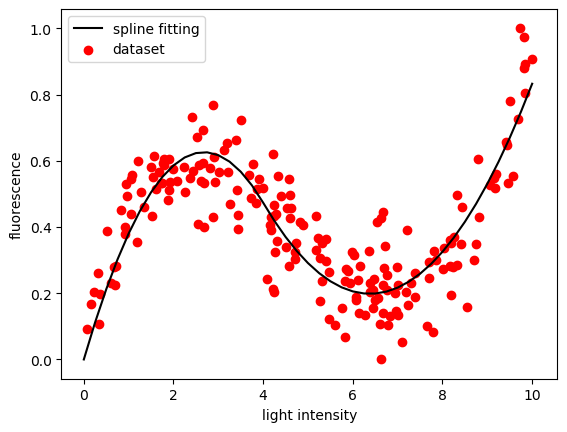

In [11]:
## plot
using PyPlot;
Xcoordinate = 0:0.25:10;
X_plot = zeros(length(Xcoordinate),K);

piece = 0; ## mark the index where there is a piece wise
for i = 1:(length(Xcoordinate)-1)
    if Xcoordinate[i] < 4 && Xcoordinate[i+1] >= 4
        piece = i;
    end
end

for i = 1:K
    X_plot[:,K - i + 1] = Xcoordinate.^(i-1);
end

Y_plot = zeros((length(Xcoordinate),1));
Y_plot[1:piece] = X_plot[1:piece,:] * value.(p);
Y_plot[piece+1:length(Xcoordinate)] = X_plot[piece+1:length(Xcoordinate),:] * value.(q);

figure();
plot(Xcoordinate,Y_plot, label = "spline fitting", c = "k");
scatter(data[:,1], data[:,2], label = "dataset", c = "r");
xlabel("light intensity");
ylabel("fluorescence");
legend();

## Q2. Voltage smoothing

\begin{align}
\underset{V_{smooth}}{\text{minimize}} \qquad& ||V_{raw} - V_{smooth}||^2 + \lambda R(V_{smooth})  \\
\end{align}

The $R()$ is a function calcuating the smoothness of a voltage
$R(x) = \sum_i^{n-1}(x_{i+1} - x_i)^2$  
The $\lambda$ is the regularization factor. 

In [12]:
using CSV
data2 = CSV.read("voltages.csv");

In [13]:
raw_volt = data2[:,1];

In [14]:
function smoothness(volt)
    L = length(volt);
    R = 0;
    for i = 1:(L-1)
        R = R + (volt[i+1] - volt[i])^2;
    end
    return R;
end

smoothness (generic function with 1 method)

In [15]:
using Ipopt, JuMP;
m2 = Model(with_optimizer(Ipopt.Optimizer));
set_silent(m2);
lambda = [10.0^i for i = -1:2];

opt_volt = zeros((length(raw_volt), length(lambda)));
new_volt = @variable(m2, [1:length(raw_volt)]);

for i = 1:length(lambda)
    @objective(m2, Min, sum((new_volt - raw_volt).^2) + lambda[i]* smoothness(new_volt));
    optimize!(m2);
    opt_volt[:,i] = value.(new_volt);
end

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      397

Total number of variables............................:      199
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

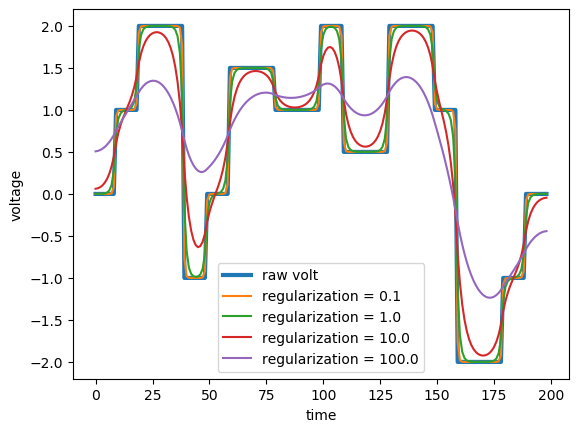

In [16]:
using PyPlot;
figure();
plot(raw_volt, label = "raw volt", linewidth = 3);
for i = 1:length(lambda)
    #LABEL = [""regularization =""]
    plot(opt_volt[:,i], label = ("regularization = "*string(lambda[i])));
end

legend();
xlabel("time");
ylabel("voltage");